In [1]:
import os
import cv2
import time
import shutil
import random
import imageio
import scipy.misc
import numpy as np
from glob import glob
import tensorflow as tf
import utils.constants as cs
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from tensorflow.python.tools import freeze_graph

/usr/share/applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                        'num_detections', 'detection_boxes', 'detection_scores',
                        'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [3]:
def load_a_frozen_model(path_to_ckpt):
    """

    This model creates a graph and load a frozen graph with created graph

    :param path_to_ckpt: string
                         checkpoint file which contains the graph information to be loaded
    :return: detection_graph : tf.Graph() object
                             : the graph information from ckpt files is loaded into this tf.Graph() object
    """
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(path_to_ckpt, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

In [4]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height, image_width):
    """Transforms the box masks back to full image masks.

    Embeds masks in bounding boxes of larger masks whose shapes correspond to
    image shape.

    Args:
      box_masks: A tf.float32 tensor of size [num_masks, mask_height, mask_width].
      boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
             corners. Row i contains [ymin, xmin, ymax, xmax] of the box
             corresponding to mask i. Note that the box corners are in
             normalized coordinates.
      image_height: Image height. The output mask will have the same height as
                    the image height.
      image_width: Image width. The output mask will have the same width as the
                   image width.

    Returns:
      A tf.float32 tensor of size [num_masks, image_height, image_width].
    """
    def transform_boxes_relative_to_boxes(boxes, reference_boxes):
        boxes = tf.reshape(boxes, [-1, 2, 2])
        min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
        max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
        transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
        return tf.reshape(transformed_boxes, [-1, 4])

    box_masks = tf.expand_dims(box_masks, axis=3)
    num_boxes = tf.shape(box_masks)[0]
    unit_boxes = tf.concat(
        [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
    reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
    image_masks = tf.image.crop_and_resize(image=box_masks,
                                           boxes=reverse_boxes,
                                           box_ind=tf.range(num_boxes),
                                           crop_size=[image_height, image_width],
                                           extrapolation_value=0.0)
    return tf.squeeze(image_masks, axis=3)

In [5]:
def detect(image, threshold=0.3):
    path_to_ckpt = cs.SSD_PB_FILE
    output_dict = run_inference_for_single_image(image, load_a_frozen_model(path_to_ckpt))
    boxes = output_dict['detection_boxes']
    classes = output_dict['detection_classes']
    scores = output_dict['detection_scores']

    for i in range(len(boxes)):
        # draw rectangles which are cars and car score > threshold
        if (classes[i] == 3 or classes[i] == 6) and scores[i] > threshold:
            rectangle_pts = boxes[i, :] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])
            cv2.putText(image, str(classes[i]),
                        (int(rectangle_pts[1]), int(rectangle_pts[0])),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (255, 255, 255),
                        2)
            cv2.rectangle(image, (int(rectangle_pts[1]), int(rectangle_pts[0])),
                          (int(rectangle_pts[3]), int(rectangle_pts[2])), (0, 255, 0), 3)
    # rectangle_pts = boxes[0, :] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])
    # print(rectangle_pts)
    # cv2.rectangle(image, (int(rectangle_pts[1]), int(rectangle_pts[0])),
    #               (int(rectangle_pts[3]), int(rectangle_pts[2])), (0, 255, 0), 3)
    # image = image[int(rectangle_pts[0]): int(rectangle_pts[2]), int(rectangle_pts[1]): int(rectangle_pts[3])]
    plt.figure(figsize=(12, 8))
    # plt.imshow(image[int(rectangle_pts[0]): int(rectangle_pts[2]), int(rectangle_pts[1]): int(rectangle_pts[3])])
    plt.imshow(image)
    plt.show()

    return image

In [6]:
def read_image(image_file):
    return scipy.misc.imread(image_file)

In [7]:
def run_detection(data_folder):

    output_dir = os.path.join(cs.RES_DIR, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)  # make a new directory where the image with detected cars will be stored

    image_paths = glob(os.path.join(data_folder, cs.JPG))
    for image_path in image_paths:

        image = read_image(image_path)  # read the image with given image_path
        image = detect(image)           # detect cars in the single image
        scipy.misc.imsave(os.path.join(output_dir,
                                       os.path.basename(image_path)), image)  # save image with detected cars

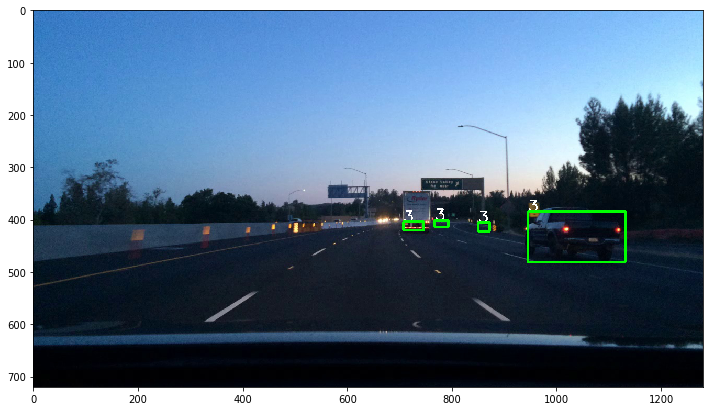

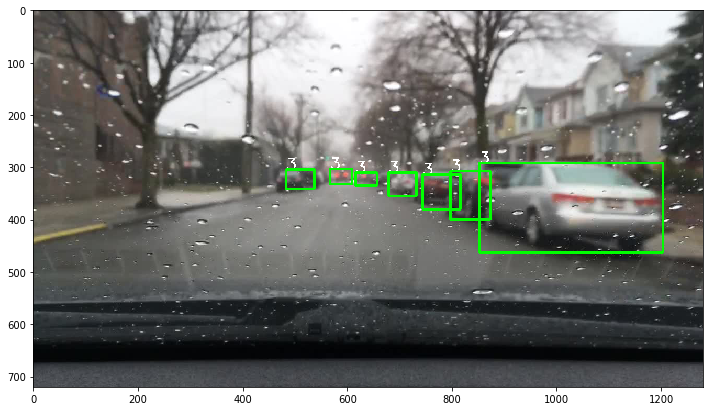

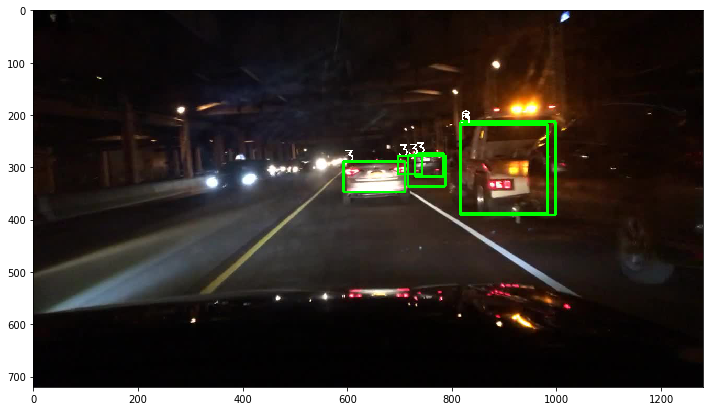

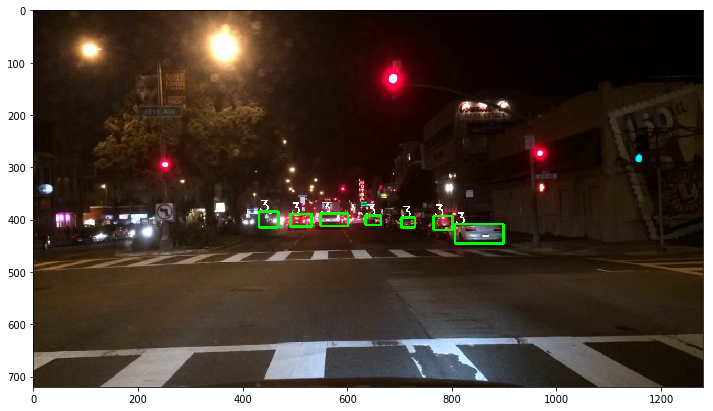

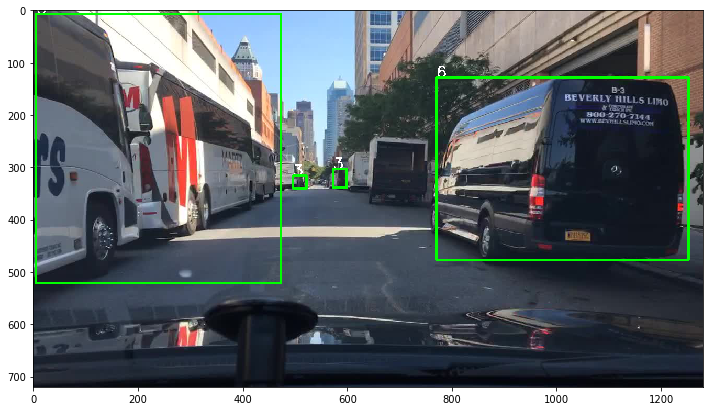

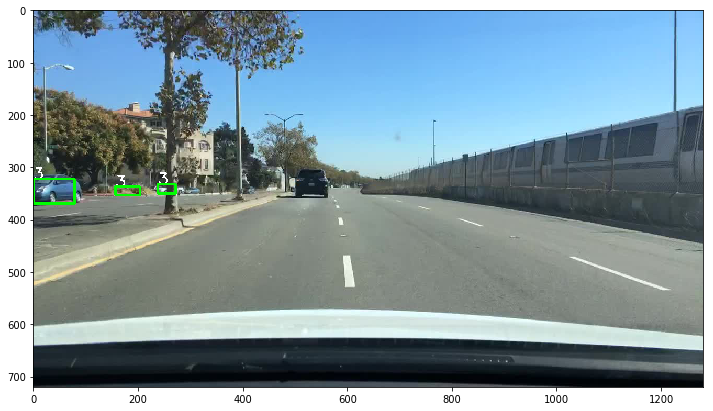

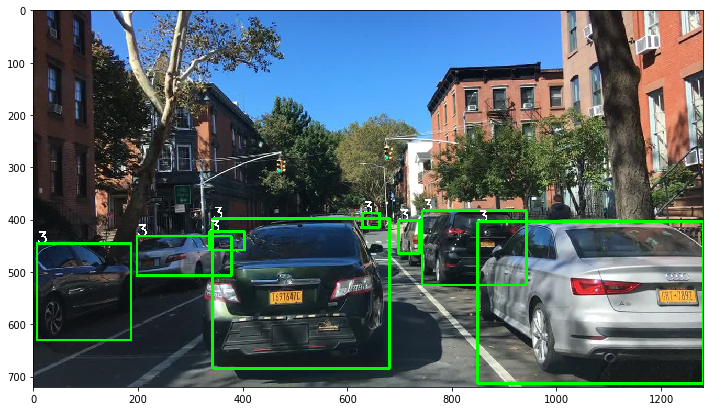

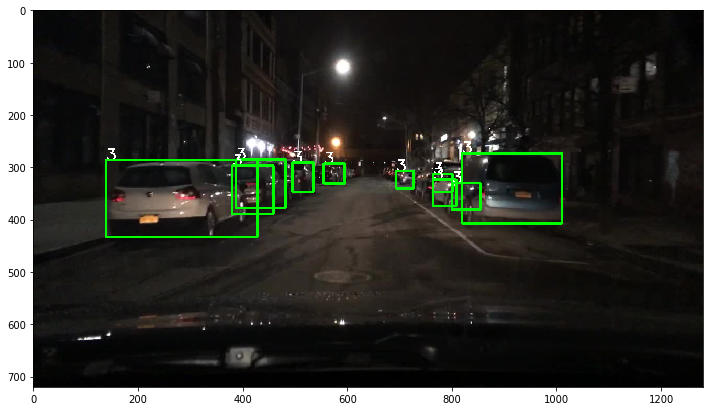

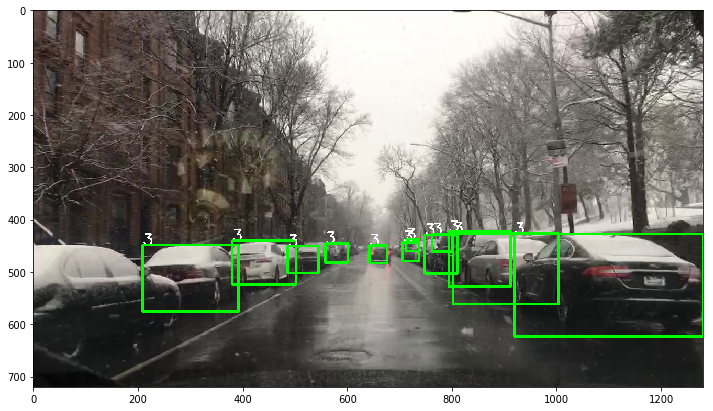

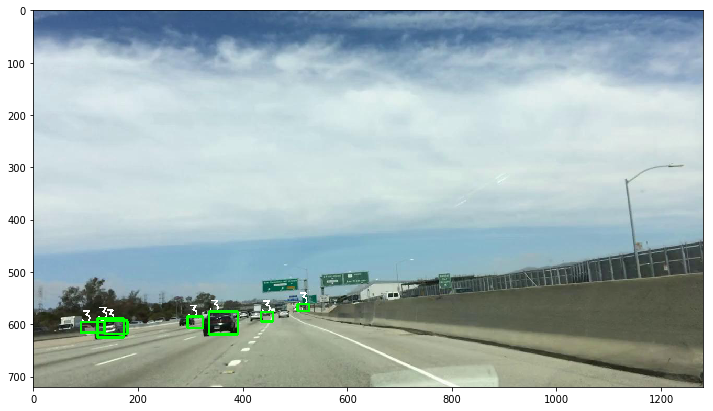

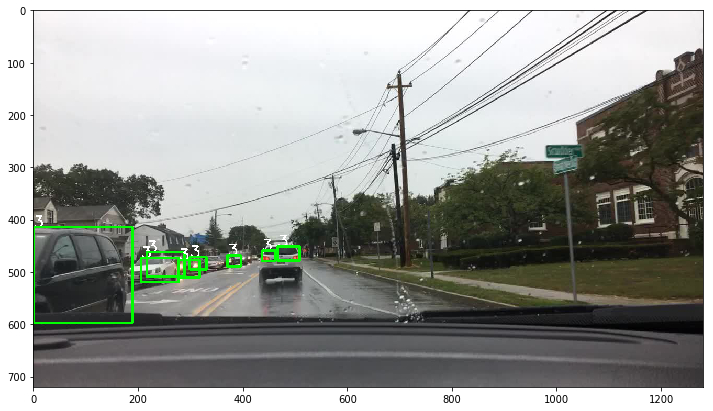

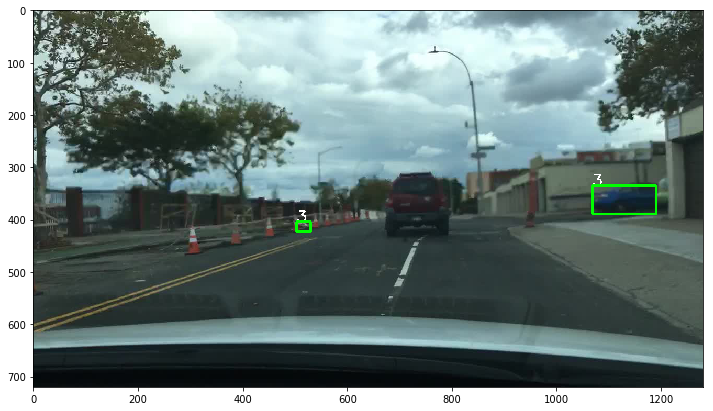

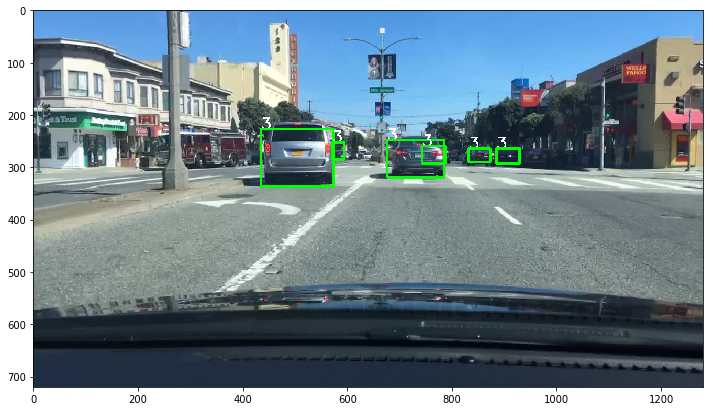

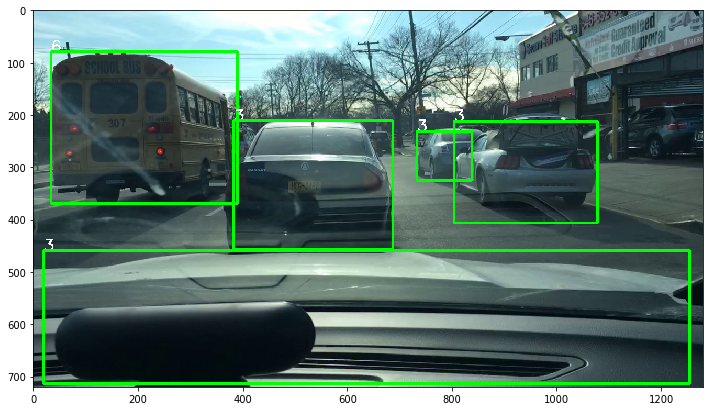

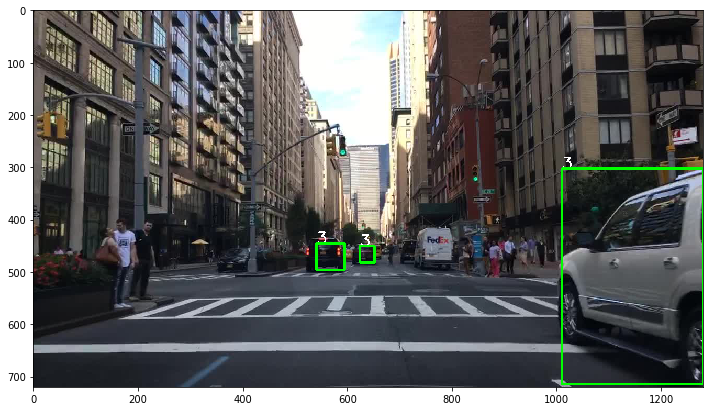

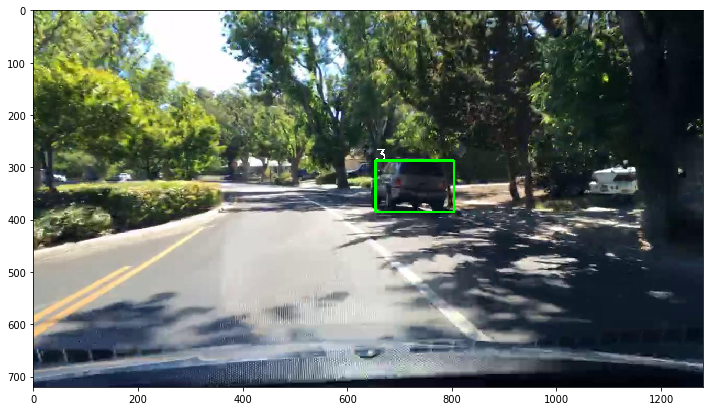

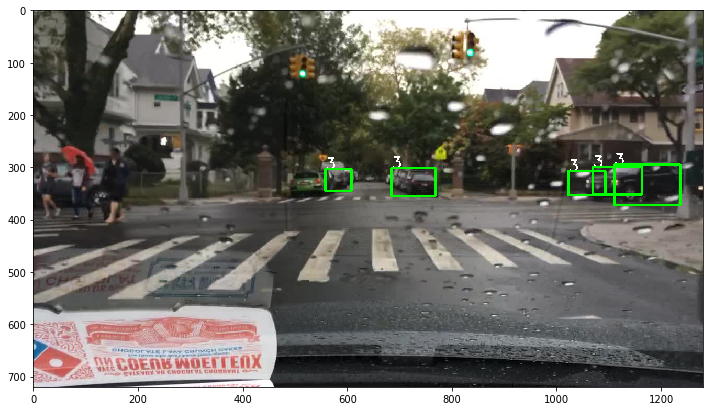

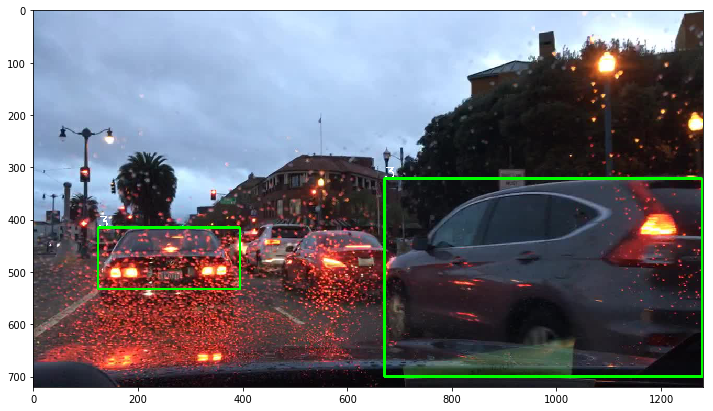

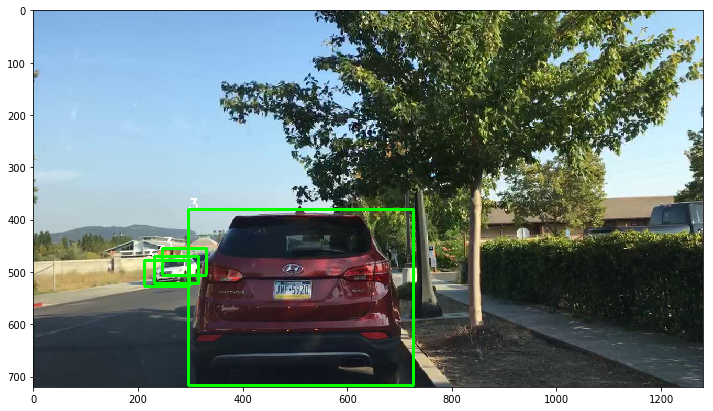

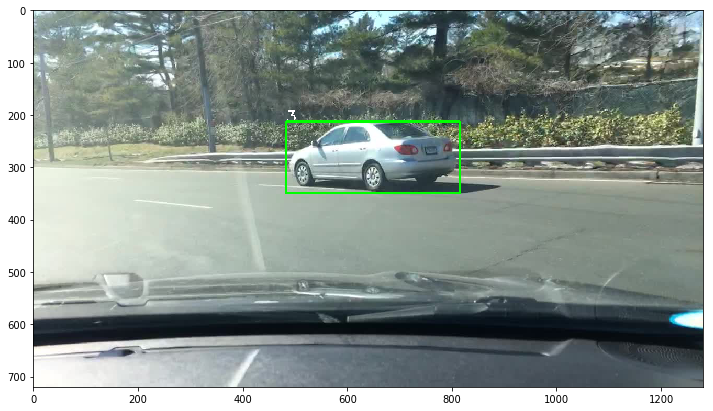

In [8]:
run_detection(cs.BORG_DATA)